# General Travelling Sales Person

In addition to being a notorious NP-hard problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. 

Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time.

The problem derives its importance from its “hardness” and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.

The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of network graphs. 

The TSP on the nodes of a graph asks for the shortest Hamiltonian cycle that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.



In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/finance/__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimizati

In [2]:
filename="instanceType_euclidean_tsp_numNodes_4_numVehicles_1_87a170c748e240d0b71d5fb7fe7de707.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [3]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]


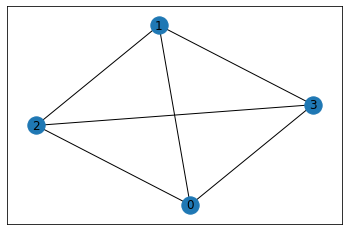

In [4]:
nx.draw_networkx(G)

In [5]:
# Create QAOA parameter dictionary
qaoa_dict = qaoa_vrp.utils.create_qaoa_params(threshold, n_max, p_max)

In [6]:
# Build Graph Feature Vector
feature_vector = qaoa_vrp.features.graph_features.get_graph_features(G)
# Build TSP Feature Vector
tsp_feature_vector = qaoa_vrp.features.tsp_features.get_tsp_features(G)
# Add num vehicles
feature_vector["num_vehicles"] = num_vehicles

In [7]:
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

In [8]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [9]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

# big_offset = sum(sum(cost_mat))/2 + 1
big_offset=30
qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info,A=big_offset)

qubos_solution_data = []

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [10]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 119.870490707263 X11 - 120 X12 - 119.870490707263 X13
      - 119.544965007869 X21 - 120 X22 - 119.544965007869 X23
      - 119.830216603413 X31 - 120 X32 - 119.830216603413 X33 + [ 120 X11^2
      + 120 X11*X12 + 120 X11*X13 + 120 X11*X21 + 0.656366125546 X11*X22
      + 120 X11*X31 + 0.573070695708 X11*X32 + 120 X12^2 + 120 X12*X13
      + 0.656366125546 X12*X21 + 120 X12*X22 + 0.656366125546 X12*X23
      + 0.573070695708 X12*X31 + 120 X12*X32 + 0.573070695708 X12*X33
      + 120 X13^2 + 0.656366125546 X13*X22 + 120 X13*X23
      + 0.573070695708 X13*X32 + 120 X13*X33 + 120 X21^2 + 120 X21*X22
      + 120 X21*X23 + 120 X21*X31 + 1.227988238243 X21*X32 + 120 X22^2
      + 120 X22*X23 + 1.227988238243 X22*X31 + 120 X22*X32
      + 1.227988238243 X22*X33 + 120 X23^2 + 1.227988238243 X23*X32
      + 120 X23*X33 + 120 X31^2 + 120 X31*X32 + 120 X31*X33 + 120 X32^2
      + 120 X32*X33 + 1

In [11]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])

# Solving the QAOA

Lets write some basic functions to find the solution from the result and also one to compute the cost based on our original graph

In [12]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [13]:
print('Offset:', offset)
print('Ising Hamiltonian:')
print(op.print_details())

Offset: 181.9830402112039
Ising Hamiltonian:
IIIIIIIIZ	(-30.218434249025503+0j)
IIIIIIZII	(-30.2184342490255+0j)
IIIIIZIII	(-30.463061791538866+0j)
IIIZIIIII	(-30.463061791538866+0j)
IIZIIIIII	(-30.310024065037577+0j)
ZIIIIIIII	(-30.31002406503758+0j)
IIIIIIIZI	(-30.307359205313634+0j)
IIIIZIIII	(-30.471088590947225+0j)
IZIIIIIII	(-30.45026473348771+0j)
IIIIIIIZZ	(15+0j)
IIIIIIZIZ	(15+0j)
IIIIIIZZI	(15+0j)
IIIIIZIIZ	(15+0j)
IIIIIZIZI	(0.082045765693287+0j)
IIIIZIIIZ	(0.082045765693287+0j)
IIIIZIIZI	(15+0j)
IIIIZIZII	(0.082045765693287+0j)
IIIIZZIII	(15+0j)
IIIZIIIZI	(0.082045765693287+0j)
IIIZIIZII	(15+0j)
IIIZIZIII	(15+0j)
IIIZZIIII	(15+0j)
IIZIIIIIZ	(15+0j)
IIZIIIIZI	(0.07163383696353035+0j)
IIZIIZIII	(15+0j)
IIZIZIIII	(0.15349852978032563+0j)
IZIIIIIIZ	(0.07163383696353035+0j)
IZIIIIIZI	(15+0j)
IZIIIIZII	(0.07163383696353035+0j)
IZIIIZIII	(0.15349852978032563+0j)
IZIIZIIII	(15+0j)
IZIZIIIII	(0.15349852978032563+0j)
IZZIIIIII	(15+0j)
ZIIIIIIZI	(0.07163383696353035+0j)
ZIIIIIZII	(15+0

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/list_ops/summed_op.py:193: DeprecationWarning: print_details() is deprecated and will be removed in a future release. Instead you can use .to_legacy_op() and call print_details() on it's output
  warnings.warn("print_details() is deprecated and will be removed in "


In [14]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 59.870491 x_0 - 60.000000 x_1 - 59.870491 x_2 - 59.544965 x_3 - 60 x_4
 - 59.544965 x_5 - 59.830217 x_6 - 60 x_7 - 59.830217 x_8 [ 60 x_0*x_1
 + 60 x_0*x_2 + 60 x_0*x_3 + 0.328183 x_0*x_4 + 60 x_0*x_6 + 0.286535 x_0*x_7
 + 60 x_1*x_2 + 0.328183 x_1*x_3 + 60 x_1*x_4 + 0.328183 x_1*x_5
 + 0.286535 x_1*x_6 + 60 x_1*x_7 + 0.286535 x_1*x_8 + 0.328183 x_2*x_4
 + 60 x_2*x_5 + 0.286535 x_2*x_7 + 60 x_2*x_8 + 60 x_3*x_4 + 60 x_3*x_5
 + 60 x_3*x_6 + 0.613994 x_3*x_7 + 60 x_4*x_5 + 0.613994 x_4*x_6 + 60 x_4*x_7
 + 0.613994 x_4*x_8 + 0.613994 x_5*x_7 + 60 x_5*x_8 + 60 x_6*x_7 + 60 x_6*x_8
 + 60 x_7*x_8 ] + 180.000000;
 
subject to {

}


In [15]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 1.2395367993452528
optimal value: [0. 1. 0. 0. 0. 1. 1. 0. 0.]
status: SUCCESS


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


In [16]:
ee = NumPyMinimumEigensolver(op)
exact_result = ee.run()

In [17]:
print('energy:', exact_result.eigenvalue.real)
print('tsp objective:', exact_result.eigenvalue.real + offset)
x = sample_most_likely(exact_result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, cost_mat))

energy: -180.74350341185865
tsp objective: 1.2395367993452453
feasible: True
solution: [2, 0, 1]
solution objective: 0.9127273476410219


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  unique, counts = np.unique(aqua_globals.random.choice(list(deterministic_counts.keys()),


## Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

We will show the callback usage below over a set of optimizers for comparison. Let's ensure we're giving each algorithm a fair shot.

- `SLSQP`
- `COBYLA`
- `NELDER_MEAD`
- `SPSA`
- `L_BFGS_B`

## Different Optimsiation Algorithms

### SLSQP
Sequential Least Squares Quadratic Programming. It essentially fits sequential parabolas to then minimize. The parameters we can tune include:

- `ftol`: Precision goal for the value of f in the stopping criterion. Default is 1e-06 *kept*
- `eps`: Step size used for numerical approximation of the Jacobian. Default for this is 1.5e-08, I set it to be 0.001
- `maxiter`: Maximum number of iterations (set to be 1000)
- `finite_diff_rel_step`: Default is `None`. 

SLSQP is ideal for mathematical problems for which the objective function and the constraints are twice continuously differentiable. In our case since, we're working with quadratic terms we suspect it should be good?


### COBYLA
Constrained Optimization BY Linear Approximation (COBYLA) algorithm. It is a numerical optimization method for constrained problems where the derivative of the objective function is not known.

The parameters we can play with are:
- `maxiter`: Maximum number of iterations (set to be 1000)
- `rhobeg`: Reasonable initial changes to the variables. Default is currently 1.0, I have set it to be 0.01.
- `tol`: None (default is 1e4).

### Nelder Mead
The Nelder–Mead method is a commonly applied numerical method used to find the minimum or maximum of an objective function in a multidimensional space.

- `maxfev` Maximum allowed number of function evaluations. If both maxiter and maxfev are set, minimization will stop at the first reached. Set to the budget of $b=1000$
- `tol` Tolerance for termination (set to 1e-04)
- `adaptive` Adapt algorithm parameters to dimensionality of problem. Set to `True`

### SPSA
Simultaneous perturbation stochastic approximation (SPSA). SPSA is an gradient descent method for optimizing systems with multiple unknown parameters. As an optimization method, it is appropriately suited to large-scale population models, adaptive modeling, and simulation optimization

### L-BFGS-B
Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory.

It assumes the objective function is a differentiable scalar function $f$. It does not require a hessian matrix. It is a method that uses limited memory, the derivatives are used to find the direction for the steepest descent.

Parameters we can tune include:

- `maxfun`: Maximum number of function evaluations.
- `factr`: The iteration stops when $\frac{(f^k - f^{k+1})}{\max{(|f^k|, |f^{k+1}|,1)}} \leq \text{factor} \times \epsilon$
- `epsilon`: Step size used (set this to be 0.001)

In [79]:
budget=70
optimizers = [
    SLSQP(maxiter=budget, disp=True, eps=0.001),
    COBYLA(maxiter=budget, disp=True, rhobeg=0.1), 
    NELDER_MEAD(maxfev=budget,disp=True,adaptive=True),
    SPSA(maxiter=budget,learning_rate=0.01,perturbation=0.01),
    L_BFGS_B(maxfun=budget,factr=10, epsilon=0.001,iprint=100)
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
backend = Aer.get_backend('aer_simulator_matrix_product_state')



/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: L_BFGS_B.__init__() keyword argument factr is deprecated and replaced with ftol. The relationship between the two is ftol = factr * numpy.finfo(float).eps. See https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html.
  return func(*args, **kwargs)


$$p = 1$$

In [80]:
p = 1
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__))
    counts = []
    values = []
    global_count = 0
    n_restart = 0
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        global global_count
        global_count += 1
        counts.append(eval_count)
        values.append(mean)
        
    while global_count < budget:
        # Increment n_restarts
        n_restart += 1
        # Initiate a random point uniformly from [0,1]
        initial_point = [np.random.uniform(0,1) for i in range(2*p)]         
        # Set random seed
        aqua_globals.random_seed = np.random.default_rng(123)
        seed = 10598
        # Initate quantum instance
        quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
        # Initate QALA
        qaoa = QAOA(
            operator=op,
            optimizer=optimizer,
            callback=store_intermediate_result,
            p=p,
            initial_point = initial_point,
            quantum_instance=quantum_instance
        )
        result = qaoa.compute_minimum_eigenvalue(operator=op)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)        
    
print('\rOptimization complete');    

Optimizer: SLSQP        
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17.421737516183057
            Iterations: 7
            Function evaluations: 85
            Gradient evaluations: 7
Optimizer: COBYLA        

   Normal return from subroutine COBYLA

   NFVALS =   28   F =-3.406907E+01    MAXCV = 0.000000E+00
   X = 7.168577E-01   8.110375E-02

   Normal return from subroutine COBYLA

   NFVALS =   28   F =-3.819304E+01    MAXCV = 0.000000E+00
   X = 6.360306E-01  -7.473995E-02

   Normal return from subroutine COBYLA

   NFVALS =   22   F =-3.825111E+01    MAXCV = 0.000000E+00
   X = 7.063593E-01   7.981503E-01
Optimizer: NELDER_MEAD        
Optimizer: SPSA        
Optimizer: L_BFGS_B        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14930D+01    |proj g|=  3.72847D+03


ITERATION     1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.




ITERATION     6

---------------- CAUCHY entered-------------------
 There are            1   breakpoints 

Piece      1 --f1, f2 at start point  -9.0750D+05  9.0750D+05
Distance to the next break point =   3.9807D-03
Distance to the stationary point =   1.0000D+00
 Variable             2   is fixed.

 GCP found in this segment
Piece      2 --f1, f2 at start point  -9.0024D+05  9.0384D+05
Distance to the stationary point =   9.9602D-01

---------------- exit CAUCHY----------------------

 Variable            2  leaves the set of free variables
           1  variables leave;            0  variables enter
           1  variables are free at GCP            6

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final functi


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Optimization complete


In [81]:
results_dict = {
    "optimizer":None,
    "n_eval": None,
    "value": None
}

optimizer_dict = {
    0: "SLSQP",
    1: "COBYLA",
    2: "NELDER_MEAD",
    3: "SPSA",
    4: "L_BFGS_B"
}

d_results = []

for i,(evals, values) in enumerate(zip(converge_cnts, converge_vals)):
    for cnt, val in zip(evals, values):
        results_dict_temp = results_dict.copy()
        results_dict_temp["n_eval"] = cnt
        results_dict_temp["value"] = val
        results_dict_temp["optimizer"] = optimizer_dict[i]
        d_results.append(results_dict_temp)

d_results = pd.DataFrame.from_records(d_results)
# Add counter for num_evals
d_results['total_evals']=d_results.groupby('optimizer').cumcount()

In [82]:
d_results.to_csv("../data/results_large_offset.csv")

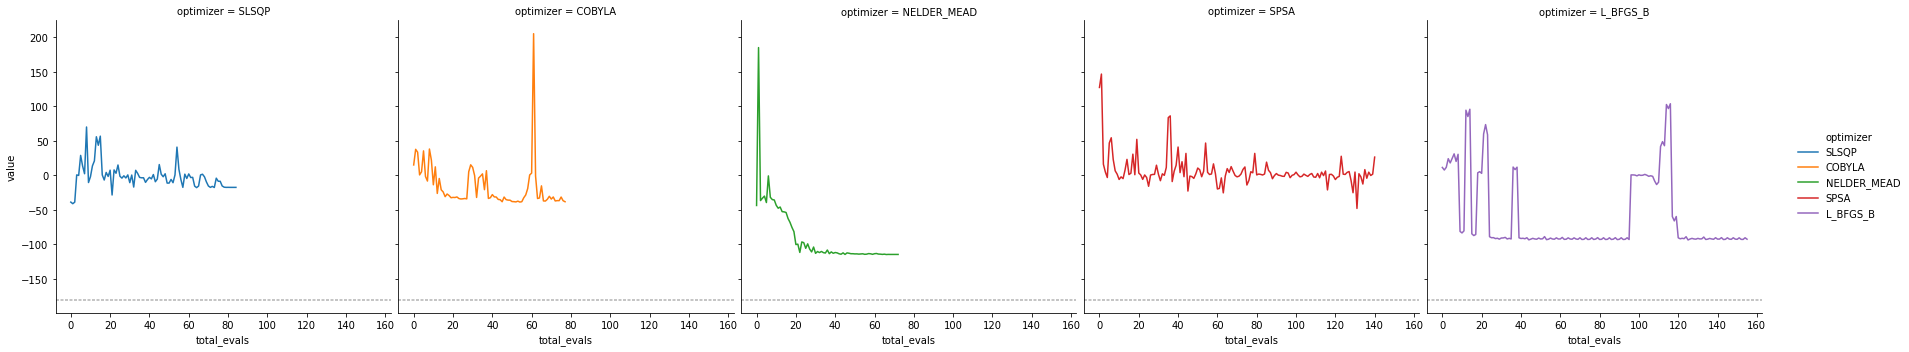

In [87]:
g = sns.relplot(
    data=d_results, x="total_evals", y="value",
    col="optimizer", hue="optimizer",
    kind="line"
)

(g.map(plt.axhline, y=-180.17, color=".7", dashes=(2, 1), zorder=0)
  .tight_layout(w_pad=0))

plt.show()

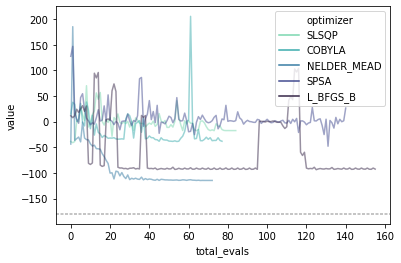

In [89]:
palette = sns.color_palette("mako_r", 5)
sns.lineplot(
    data=d_results, x="total_evals", y="value",
    hue="optimizer",
    palette=palette,
    alpha=0.5
)
plt.axhline(y=-180.17, color=".7", dashes=(2, 1), zorder=0)

In [85]:
x = sample_most_likely(result.eigenstate)
tsp.get_tsp_solution(x)

[2, 0, 1]

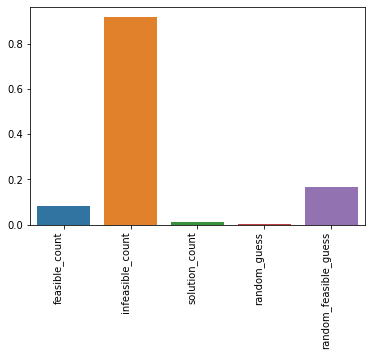

In [90]:
plt.clf()
feasible_count = 0
infeasible_count = 0
solution_count = 0
feasibility_results = {
    "feasible_count": None,
    "infeasible_count": None,
    "solution_count": None,
    "random_guess": None
}

num_feasible = len([x for x in result.eigenstate.keys() if tsp.tsp_feasible(x)])

for state in result.eigenstate.keys():
    x = sample_most_likely(exact_result.eigenstate)
    exact_sol_state = ''.join([str(i) for i in x])
    if tsp.tsp_feasible(state):
        feasible_count += result.eigenstate[state]
    else:
        infeasible_count += result.eigenstate[state]
    if exact_sol_state == state:
        solution_count = result.eigenstate[state]

feasibility_results["feasible_count"]=feasible_count
feasibility_results["infeasible_count"]=infeasible_count
feasibility_results["solution_count"]=solution_count
feasibility_results["random_guess"]=(feasible_count+infeasible_count)/2**num_qubits
feasibility_results["random_feasible_guess"]=(feasible_count+infeasible_count)/num_feasible
keys = list(feasibility_results.keys())
# # get values in the same order as keys, and parse percentage values
vals = [feasibility_results[k]/1024 for k in keys]
feasible_plot = sns.barplot(x=keys, y=vals)
feasible_plot.set_xticklabels(feasible_plot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

In [96]:
result.eigenstate['010001100']
13/1024

0.0126953125

In [98]:
for state in result.eigenstate.keys():
    x = sample_most_likely(exact_result.eigenstate)
    exact_sol_state = ''.join([str(i) for i in x])
    if tsp.tsp_feasible(state):
        feasible_count += result.eigenstate[state]
    else:
        infeasible_count += result.eigenstate[state]
    if exact_sol_state == state:
        solution_count = result.eigenstate[state]

{'111100001': 1,
 '010110000': 1,
 '110011000': 1,
 '010010011': 1,
 '100111001': 1,
 '100100110': 2,
 '011010010': 1,
 '110001110': 1,
 '011011010': 1,
 '010101111': 1,
 '001011001': 1,
 '000000000': 1,
 '000101100': 1,
 '001101100': 1,
 '011110100': 1,
 '000000110': 2,
 '001110110': 2,
 '010110110': 1,
 '011101001': 1,
 '010111110': 1,
 '010010010': 1,
 '100010110': 1,
 '011000001': 1,
 '000100111': 1,
 '101001001': 1,
 '100010101': 4,
 '101001100': 1,
 '000000010': 1,
 '110111010': 1,
 '010010100': 3,
 '101000110': 1,
 '000100000': 1,
 '100100001': 3,
 '100011101': 2,
 '100011000': 4,
 '101110010': 1,
 '010111001': 2,
 '000101101': 2,
 '110101100': 2,
 '110110100': 1,
 '011010101': 1,
 '011000111': 1,
 '001010000': 3,
 '011101100': 2,
 '000101001': 2,
 '000101110': 1,
 '110001100': 5,
 '001000000': 2,
 '110101111': 1,
 '011101010': 2,
 '101110101': 1,
 '000110011': 2,
 '000000001': 2,
 '000101000': 2,
 '110000011': 2,
 '000100010': 5,
 '100000001': 3,
 '000001000': 1,
 '001101110': 